# Modele Seq2Seq i atencja
Poniższy notebook jest inspirowany tym tutorialem PyTorcha: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html. Zachęcam żeby zajrzeć tam po więcej informacji.

W tym notebooku będziemy próbować rozwiązać problem automatycznego tłumaczenia zdań z jednego języka naturalnego na drugi -- konkretniej z języka polskiego na angielski. Dla przykładu model otrzymujący zdanie:

> Myślę, że mnie okłamałeś

Powinien zwrócić zdanie
> I think you lied to me.



# Importy i przygotowanie danych
Poniżej znajdują się importy bibliotek potrzebnych do rozwiązania problemu a także skrypt do ładowania zbioru danych zawierającego pary zdań w języku polskim i angielskim. Poniższy kod można odpalić i schować, ale zachęcamy do zaznajomienia się z tym jak wygląda obróbka danych.


In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import unicodedata
import string
import numpy as np
import re
import random
import seaborn as sns

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchtext.data.metrics import bleu_score

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Poniżej przygotowujemy klasę `Lang` która będzie służyła jako struktura do obsługiwania naszego języka (osobna dla angielskiego i polskiego w naszym przypadku). Do każdego słowa w języku przypisujemy indeks (liczbę porządkową identyfikującą słowo). Dodatkowo definiujemy trzy dodatkowe indeksy:

* 0 dla początku zdania (Start of Sentence, SOS)
* 1 dla końca zdania (End of Sentence, EOS)
* 2 dla paddingu ("pustych" wartości). Wartościami tymi będziemy wypełniać zdania w batchu tak, żeby wszystkie były równej długości -- dzięki temu łatwiej będzie zrównoleglić przetwarzanie ich na GPU.

In [4]:
SOS_token = 0
EOS_token = 1
PAD_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "PAD"}
        self.n_words = 3 # Count SOS, EOS and PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Funkcje do normalizowania wchodzących zdań - zamieniamy Unicode na ASCII, zamieniamy wszystkie wielkie litery na małe itd.

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = s.replace("ł", "l")
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('eng-pol.txt', encoding='utf-8').\
        read().strip().split('\n')
    lines = lines[1:]  # Skip first line with attributions.

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[1::2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Wyrzućmy zdania które są zbyt długie (ponad 20 słów).

In [6]:
MAX_LENGTH = 20

def filterPair(p):
    return len(p[0].split(' ')) <= MAX_LENGTH and \
        len(p[1].split(' ')) <= MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Pełny proces przetwarzania danych wygląda następująco:

- Wczytujemy plik z danymi, dzielimy go na pary zdań.
- Normalizujemy tekst
- Zamieniamy zdania w listy słów.




In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print(pairs[0])
    print(f"Read {len(pairs)} sentence pairs")
    pairs = filterPairs(pairs)
    print(f"Trimmed to {len(pairs)} sentence pairs")
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('pol', 'eng', True)
print("Przykładowe pary zdań:")
for _ in range(3):
    print(random.choice(pairs))

Reading lines...
['sprobujmy cos .', 'let s try something .']
Read 59749 sentence pairs
Trimmed to 59404 sentence pairs
Counting words...
Counted words:
eng 29246
pol 11953
Przykładowe pary zdań:
['tom przyspieszyl .', 'tom accelerated .']
['zapomnij o niej .', 'forget about her .']
['powinienes starac sie byc bardziej optymistycznym .', 'you should try being more optimistic .']


Na koniec definiujemy jeszcze funkcje, które pozwolą nam zamienić zdania w tensory, które nasza sieć będzie w stanie zrozumieć.

In [8]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


def pad_sequences(data_batch):
    pl_batch, en_batch = [], []
    for pl_sentence, en_sentence in data_batch:
        pl_batch += [pl_sentence]
        en_batch += [en_sentence]
    pl_batch = pad_sequence(pl_batch, padding_value=PAD_token, batch_first=True)
    en_batch = pad_sequence(en_batch, padding_value=PAD_token, batch_first=True)
    return pl_batch, en_batch

def prepare_dataset(batch_size):
    rng = np.random.RandomState(567)
    indices = np.arange(len(pairs))
    rng.shuffle(indices)
    train_indices = indices[:int(len(pairs) * 0.8)]
    test_indices = indices[int(len(pairs) * 0.8):]
    train_pairs = list(pairs[idx] for idx in train_indices)
    test_pairs = list(pairs[idx] for idx in test_indices)
    tensor_train_pairs = [tensorsFromPair(pairs[idx]) for idx in train_indices]
    tensor_test_pairs = [tensorsFromPair(pairs[idx]) for idx in test_indices]
    reference_translation = test_pairs

    # Output in natural language?

    train_loader = DataLoader(tensor_train_pairs, batch_size=batch_size,
                            shuffle=True, collate_fn=pad_sequences)
    test_loader = DataLoader(tensor_test_pairs, batch_size=batch_size,
                            shuffle=True, collate_fn=pad_sequences)
    return train_pairs, test_pairs, train_loader, test_loader

# Model Seq2Seq



W tym celu wykorzystany rekurencyjne sieci neuronowe (RNN-y), które poznaliśmy na poprzednich zajęciach. Konkretniej zbudujemy za ich pomocą model Sequence to Sequence (Seq2Seq), w której wykorzystamy dwie sieci rekurencyjne:
1. Enkoder, który będzie przyjmował kolejno słowa ze zdania wejściowego i kompresował informacje o nich w swoim stanie ukrytym.
2. Dekoder, który będzie generował kolejne słowa w języku docelowym. 

![seq2seq](https://docs.chainer.org/en/stable/_images/seq2seq.png)
Źródło: https://docs.chainer.org/

## Funkcje pomocnicze i ewaluacyjne

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def predict(encoder, decoder, inputs, targets=None, max_len=MAX_LENGTH):
    batch_size = inputs.size(0)

    encoder_outputs, encoder_hidden = encoder(inputs)

    decoder_input = torch.tensor([[SOS_token]] * batch_size, device=device)
    decoder_hidden = encoder_hidden
    decoder_output, decoder_attention = decoder(
        decoder_input,
        decoder_hidden,
        targets=targets,
        max_len=max_len,
        encoder_outputs=encoder_outputs)
    return decoder_output, decoder_attention

def translate(encoder, decoder, sentence, show_attention=True):
    inputs = tensorFromSentence(input_lang, sentence).unsqueeze(0).cuda()
    decoder_output, decoder_attention = predict(encoder, decoder, inputs)

    decoded_words = []
    for word in decoder_output[0]:
        top_word = word.argmax(-1).item()
        decoded_words.append(output_lang.index2word[top_word])
        if top_word == EOS_token:
            break

    if decoder_attention is not None and show_attention:
        # [out_words, in_words]
        att = decoder_attention.cpu().detach().numpy()
        att = att[0, :len(decoded_words), :]
        fig, ax = plt.subplots()

        im = ax.imshow(att, vmin=0, vmax=1)
        ax.xaxis.tick_top()
        ax.set_xticklabels([''] + sentence.split(' ') +
                        ['EOS'], rotation=90)
        ax.set_yticklabels([''] + decoded_words)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)

        fig.colorbar(im, cax=cax, orientation='vertical')
        
        ax.tick_params(axis='both', which='major', labelsize=12)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        plt.show()

    return decoded_words

def batch_translate(encoder, decoder, batch):
    decoder_output, decoder_attention = predict(encoder, decoder, batch)

    predicted_sentences = []

    # TODO: potentially paralellize?
    for batch_idx in range(len(batch)):
        predicted_words = []
        for word in decoder_output[batch_idx]:
            top_word = word.argmax(-1).item()
            if top_word == EOS_token:
                break
            predicted_words.append(output_lang.index2word[top_word])

        predicted_sentences.append(predicted_words)

    return predicted_sentences

def dataset_translate(encoder, decoder, loader):
    predicted_sentences = []
    reference_sentences = [] 
    for batch_in, batch_out in loader:
        translated = batch_translate(encoder, decoder, batch_in)
        predicted_sentences.extend(translated)

        # TODO: move to a separate file?
        reference_words = []
        for sentence_idx, sentence in enumerate(batch_out):
            decoded_sentence = []
            for word in sentence:
                if word.item() == EOS_token:
                    break
                decoded_sentence.append(output_lang.index2word[word.item()])
            reference_sentences.append(decoded_sentence)
    
    return predicted_sentences, reference_sentences


def translate_randomly(encoder, decoder, pairs, n=10):
    # TODO: reuse translate_given_pairs
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = translate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

def translate_given_pairs(encoder, decoder, pairs):
    for pair in pairs:
        print('>', pair[0])
        print('=', pair[1])
        output_words = translate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
def plot_results(bleus, losses):
    sns.set_style('whitegrid')

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    axes[0].plot(np.arange(len(bleus)), bleus)
    axes[0].set_xlabel("Epoka")
    axes[0].set_ylabel("BLEU")
    axes[1].plot(np.arange(len(losses)), losses)
    axes[1].set_xlabel("Epoka")
    axes[1].set_ylabel("Koszt na zbiorze treningowym")

## Pętla trenująca

In [10]:
def train(encoder, decoder, lr=0.01, batch_size=256, teacher_forcing_ratio=0.5, epochs_num=100, clipping=1.0):

    # Prepare dataset, loss functions, optimizer
    train_pairs, test_pairs, train_loader, test_loader = prepare_dataset(batch_size)

    criterion = nn.CrossEntropyLoss(ignore_index=PAD_token)

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)

    encoder.cuda()
    decoder.cuda()

    bleus = []
    train_losses = []

    for epoch in range(epochs_num + 1):

        # Training
        epoch_train_loss = 0.
        for in_batch, out_batch in train_loader:
            in_batch, out_batch = in_batch.cuda(), out_batch.cuda()

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
        
            teacher_inputs = out_batch if random.random() < teacher_forcing_ratio else None
        
            decoder_output, decoded_attention = predict(
                encoder, decoder, in_batch,
                targets=teacher_inputs,
                max_len=out_batch.size(1)
            )

            loss = criterion(decoder_output.transpose(1, 2), out_batch)
            
            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(encoder.parameters(), clipping)
            nn.utils.clip_grad_norm_(decoder.parameters(), clipping)

            encoder_optimizer.step()
            decoder_optimizer.step()

            epoch_train_loss += loss.item()

        # Evaluation
        if epoch % 1 == 0:
            with torch.no_grad():
                print("=" * 25, "Translation test", "=" * 25)
                translate_randomly(encoder, decoder, test_pairs, n=5)

            pred_sentences, ref_sentences = dataset_translate(encoder, decoder, test_loader)
            bleu_val = bleu_score(pred_sentences, [[sentence] for sentence in ref_sentences])
            print("=" * 25, f"BLEU: {bleu_val}", "=" * 25)
            bleus += [bleu_val]

        mean_train_loss = epoch_train_loss / len(train_loader)
        train_losses += [mean_train_loss]
        print(f"Epoch: {epoch}. Train loss: {mean_train_loss}")
    return bleus, train_losses

<h4> Zadanie 1 - Dekoder w Seq2Seq </h4>

W tym zadaniu należy zaimplementować dekoder z modelu Seq2Seq. Kod enkodera jest dostępny poniżej i ma Państwu ułatwić odpowiednie zaimplementowanie dekodera.

Dekoder otrzymuje na wejściu następujące argumenty:
- `input` - tensor o wymiarach `[batch_size, 1]` zawierający słowo `<BOS>`. Powinno być podane w pierwszym kroku wykonywania dekodera.
- `hidden` - ostatnia reprezentacja ukryta z enkodera .
- `targets` - `None` albo `torch.tensor` o wymiarach `[batch_size, seq_len]` zawierający indeksy słów w języku docelowym. Jeżeli jest podany to należy zaimplementować teacher forcing na jego podstawie.
- `max_len` - Długość sekwencji, którą mamy zwrócić.
- `encoder_outputs` - w tym zadaniu ten argument należy zignorować, przyda się dopiero w kolejnym zadaniu.

Dekoder ma zwrócić dwie zmienne:
- `output` - tensor o wymiarach `[batch_size, max_len, vocab_size]` reprezentujące logity, które po zaaplikowaniu softmaksa (co będzie zrobione już poza dekoderem) będą reprezentowały prawdopodobieństwa słów przewidzianych przez nasz dekoder.
- `attention_weights` - w tym zadaniu należy zawsze zwracać `None`.

Architektura głowy klasyfikacyjnej jest dowolna, natomiast zalecamy sieć z jedną warstwą ukrytą: `[hidden_size, hidden_size, vocab_size]` i aktywacją tanh.


**HINT 1**: Warto pamiętać o argumencie `batch_first=True` przy definiowaniu RNN-a.

**HINT 2**: W enkoderze mogliśmy użyć jednego wywołania klasy GRU, jako że od razu mieliśmy wszystkie wejścia (słowa języka wejściowego). W przypadku dekodera nie jest to możliwe, jako że wejściem w kroku `t+1` jest wyjście z kroku `t`. Oznacza to że prawdopodobnie potrzebna będzie pętla `for`.

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn_cell = nn.GRU(embedding_size, hidden_size, batch_first=True)

    def forward(self, input):
        embedded = self.embedding(input)
        output, hidden = self.rnn_cell(embedded)
        return output, hidden

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(DecoderRNN, self).__init__()
        ???

    def forward(self, input, hidden, targets=None, max_len=None, encoder_outputs=None):
        ???
        return output, None

========================= Translation test =========================
> layla jest twoja corka .
= layla is your daughter .
< i s t a . EOS

> zrobie to jesli mi zaplaca .
= i ll do it if they pay me .
< i s t a . . EOS

> naprawde chcesz jechac cala noc ?
= are you seriously thinking about driving all night ?
< i you you you you ? EOS

> czy wierzysz we wrozki ?
= do you believe in fairies ?
< you you you ? EOS

> zaczal pisac powiesc .
= he has started to write a novel .
< i s a . EOS

========================= BLEU: 0.0 =========================
Epoch: 0. Train loss: 5.502909875685169
========================= Translation test =========================
> po prostu jestes zazdrosna .
= you re just jealous .
< i m a . . . EOS

> moj pokoj jest bardzo maly .
= my room is very small .
< the is is a lot . EOS

> cos zlego mialo sie zaraz wydarzyc .
= something bad was about to happen .
< i was a lot of the car . EOS

> nigdy o nich nie slyszalem .
= i ve never heard of them .
< i m not to

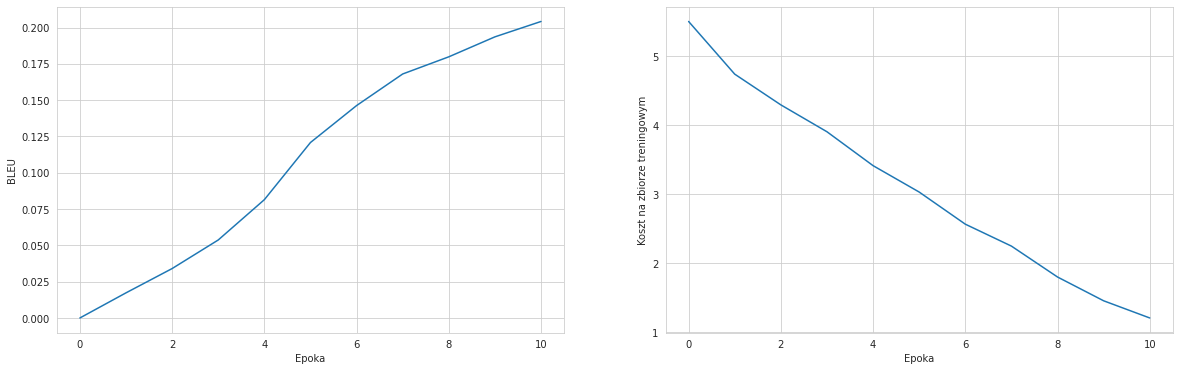

In [13]:
hidden_size = 1024
embedding_size = 512
lr = 1e-3

encoder = EncoderRNN(input_lang.n_words, embedding_size, hidden_size).to(device)
decoder = DecoderRNN(output_lang.n_words, embedding_size, hidden_size).to(device)

bleus, losses = train(encoder, decoder, batch_size=512, lr=lr, epochs_num=10, clipping=0.1)
plot_results(bleus, losses)

<h4> Zadanie 2 - Atencja w RNN-ach </h4>

![seq2seq z dekoderem](https://www.researchgate.net/profile/Chandan_Reddy6/publication/329464533/figure/fig3/AS:701043021197314@1544153089772/An-attention-based-seq2seq-model.ppm)

Źródło: https://github.com/google/seq2seq

W tym zadaniu należy napisać kod nowego dekodera, który ma działać podobnie jak dekoder w poprzednim zadaniu, ale jednocześnie ma wykorzystywać mechanizm atencji.

W normalnym dekoderze, w kroku `t` wejściem do komórki GRU (pomijamy tutaj przekazywanie stanu ukrytego) była wyłącznie zembeddowana reprezentacja $\bar{y}_t$. W dekoderze z atencją na wejściu podawna będzie konkatenacja tego wektora oraz specjalnego wektora $z_t$ stworzonego na podstawie wyjść z enkodera: $\tilde{h}_t = [\bar{y}_t, z_t]$. 

Wektor $z_t$ jest pozyskiwany za pomocą mechanizmu atencji. Intuicyjnie chcielibyśmy w nim zebrać informacje z enkodera, które będą najistotniejsze przy dekodowaniu aktualnego słowa. Przyjmijmy, że mamy funkcję alignmentu $a(h, e)$, która jest nam w stanie powiedzieć jak bardzo podobne do siebie są stan ukryty dekodera $h$ oraz reprezentacja słowa $e$.

Wtedy 

$$
\begin{align}
w_i &= \frac{ \exp(a(h, e_i)) }{\sum_{j} \exp(a(h, e_j))} \\
z_t &= \sum_i e_i \cdot w_i
\end{align}
$$


W naszym wypadku funkcja alignmentu $a(h, e)$ ma być siecią neuronową z dwoma warstwami o kolejnych wymiarach: `[2 * hidden_size, hidden_size, 1]` i aktywacją tanh po pierwszej warstwie.

Argumenty wejściowe i wyjściowe z dekodera są takie same jak w poprzednim z zadaniu z wyjątkiem:
- Tym razem na wejściu otrzymujemy tensor `encoder_outputs` o wymiarach `[batch_size, encoder_seq_len, hidden_size]`. To są reprezentacje $e_i$, które należy wykorzystać w mechanizmie atencji.
- Tym razem na wyjściu `attention_weights` powinno być tensorem o wymiarach `[batch_size, decoder_seq_len, encoder_seq_len]` zawierającym wagi $w_i$. **HINT:** wartości tego tensora powinny się sumować do jedynki na ostatnim wymiarze.

In [14]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(AttnDecoderRNN, self).__init__()
        ???

    def forward(self, input, hidden, targets=None, max_len=None, encoder_outputs=None):
        ???
        return output, seq_att_weights

========================= Translation test =========================
> czy moglbys sie pospieszyc ?
= could you please hurry ?


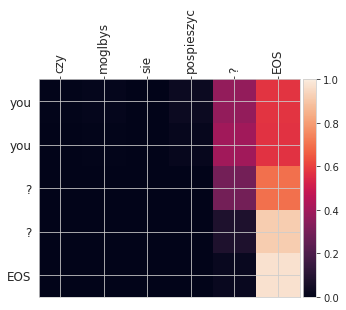

< you you ? ? EOS

> jestes przygotowany ?
= are you prepared ?


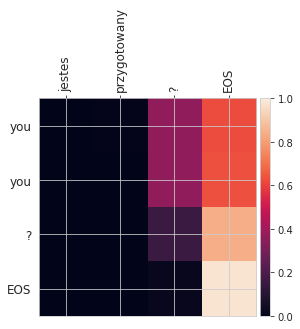

< you you ? EOS

> mary ma prawo zrobic co zechce .
= mary is allowed to do what she wants .


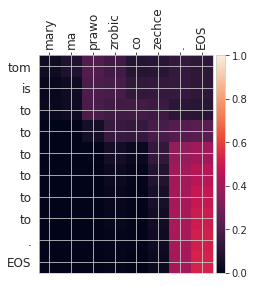

< tom is to to to to to to . EOS

> jak szybko mozesz skonczyc te obrazy ?
= how quickly can you finish these pictures ?


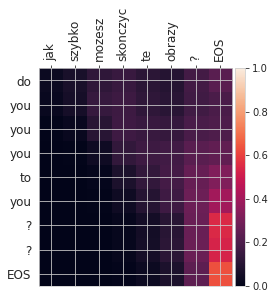

< do you you you to you ? ? EOS

> dlaczego jestes o mnie zazdrosna ?
= why are you jealous of me ?


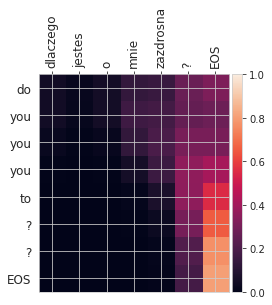

< do you you you to ? ? EOS

========================= BLEU: 0.004633124376274396 =========================
Epoch: 0. Train loss: 5.320768663960118
========================= Translation test =========================
> policjant zatrzymal go za przekroczenie predkosci .
= the policeman arrested him for speeding .


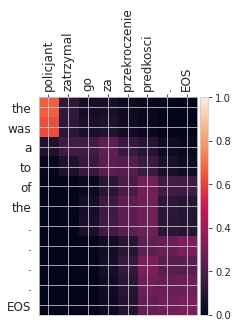

< the was a to of the . . . . EOS

> tom wierzyl ze mary postapi slusznie .
= tom trusted mary to do the right thing .


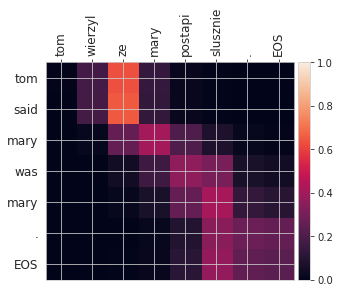

< tom said mary was mary . EOS

> naprawde chce wiedziec co tu sie dzieje .
= i really want to know what s happening here .


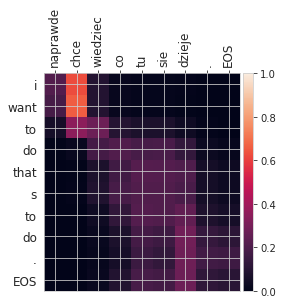

< i want to do that s to do . EOS

> czekam .
= i am waiting .


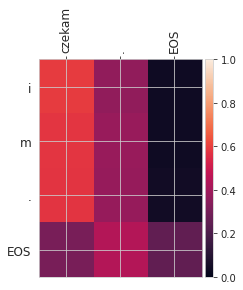

< i m . EOS

> moj ojciec tu jest .
= my father is here .


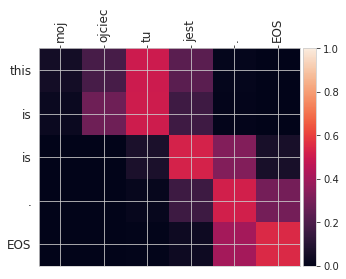

< this is is . EOS

========================= BLEU: 0.03958661094582621 =========================
Epoch: 1. Train loss: 4.478401432755173
========================= Translation test =========================
> ona slucha muzyki .
= she is listening to music .


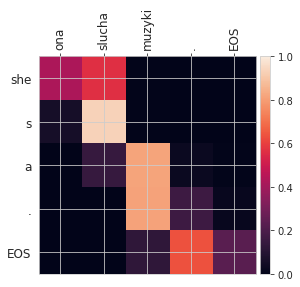

< she s a . EOS

> bardzo za toba tesknilem .
= i missed you very much .


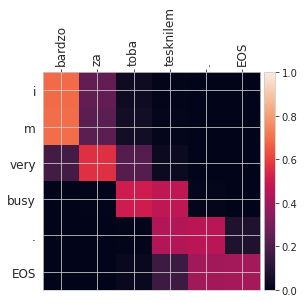

< i m very busy . EOS

> nie musisz tego robic .
= you don t have to do it .


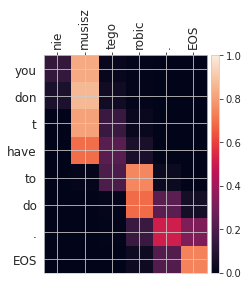

< you don t have to do . EOS

> tom lubi swja prace .
= tom loves his work .


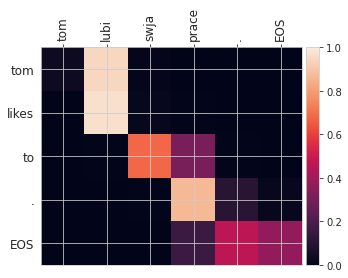

< tom likes to . EOS

> dlaczego ludzie popelniaja samobojstwa ?
= why do people kill themselves ?


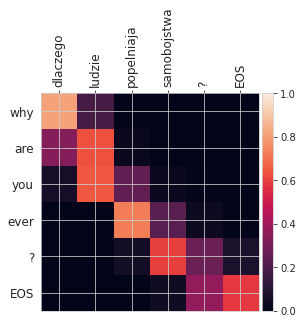

< why are you ever ? EOS

========================= BLEU: 0.0863698467709789 =========================
Epoch: 2. Train loss: 3.839403542139197
========================= Translation test =========================
> zamknij sie i posluchaj .
= shut up and listen .


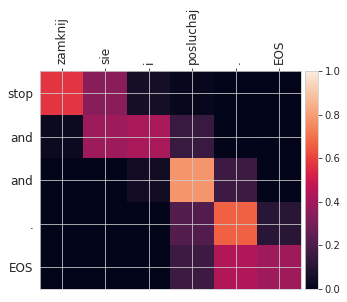

< stop and and . EOS

> nie zmienie zdania nie wazne co sie stanie .
= i shall not change my mind whatever happens .


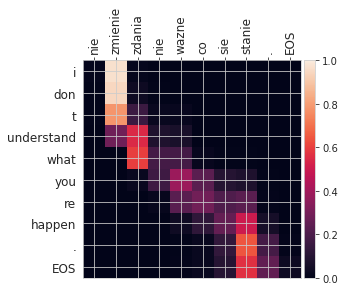

< i don t understand what you re happen . EOS

> tom zawsze byl cichym dzieckiem .
= tom was always a quiet child .


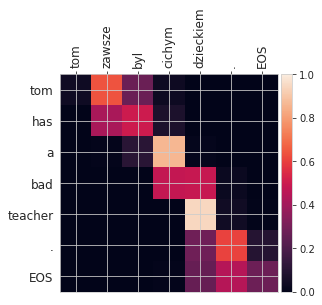

< tom has a bad teacher . EOS

> tom byl wtedy zonaty .
= tom was married back then .


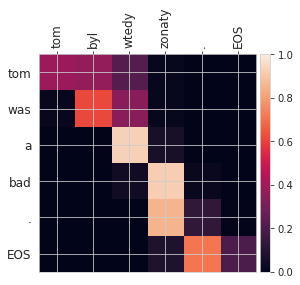

< tom was a bad . EOS

> to wszystko czego mi trzeba .
= that s all i need .


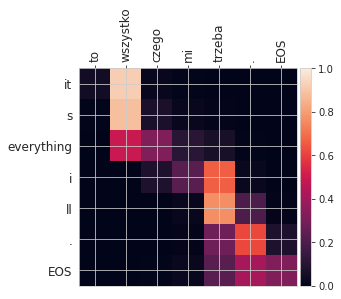

< it s everything i ll . EOS

========================= BLEU: 0.1494931678268897 =========================
Epoch: 3. Train loss: 3.1962038009397444
========================= Translation test =========================
> teraz po prostu przesadzasz .
= now you re just overreacting .


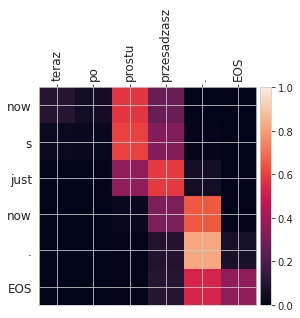

< now s just now . EOS

> badz mily .
= be friendly .


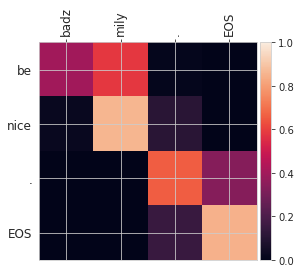

< be nice . EOS

> kto jadl ?
= who ate ?


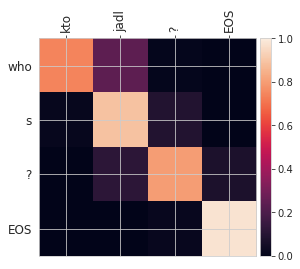

< who s ? EOS

> nie mow z pelnymi ustami .
= don t talk with your mouth full .


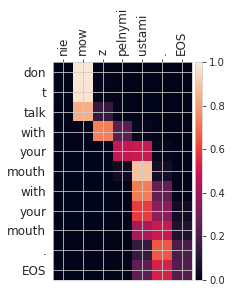

< don t talk with your mouth with your mouth . EOS

> spoznil sie o godzine co mnie bardzo zdenerwowalo .
= he arrived an hour late which annoyed me very much .


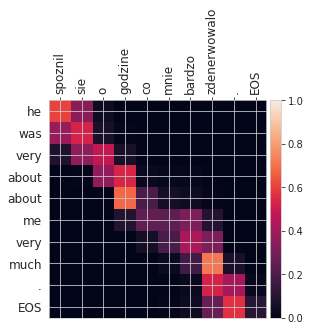

< he was very about about me very much . EOS

========================= BLEU: 0.20843314303012583 =========================
Epoch: 4. Train loss: 2.5548645142586
========================= Translation test =========================
> nie odpowiedzial na moj list .
= he didn t reply to my letter .


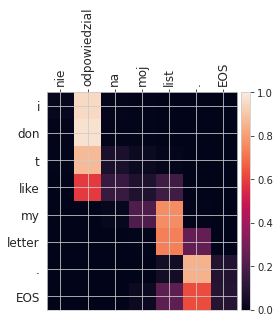

< i don t like my letter . EOS

> usmiech pojawil sie na mojej twarzy .
= a smile crossed my face .


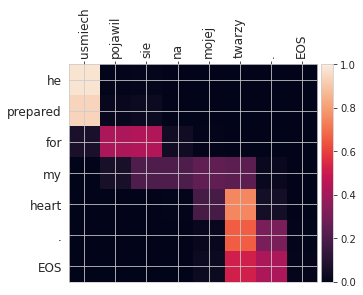

< he prepared for my heart . EOS

> bardzo bym chcial sie z toba zobaczyc .
= i m dying to see you .


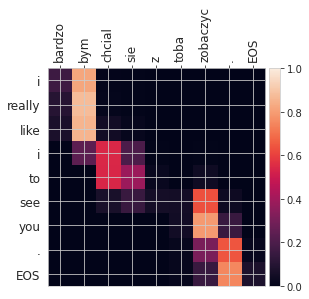

< i really like i to see you . EOS

> mary jest moja najlepsza przyjaciolka .
= mary is my best friend .


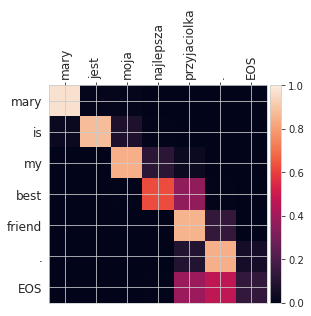

< mary is my best friend . EOS

> tom moglby znac odpowiedz .
= tom might know the answer .


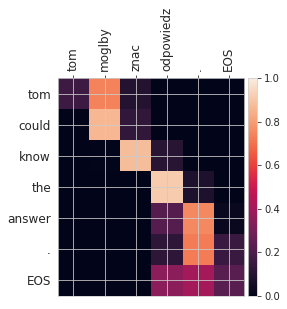

< tom could know the answer . EOS

========================= BLEU: 0.2315752091817419 =========================
Epoch: 5. Train loss: 2.0708920007110923
========================= Translation test =========================
> tony umie szybko biegac .
= tony can run fast .


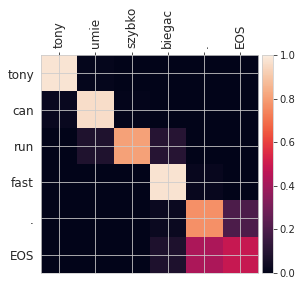

< tony can run fast . EOS

> ile czasu to zajmie ?
= how long would it take ?


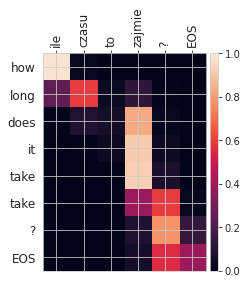

< how long does it take take ? EOS

> nie zazwyczaj ogladam je w domu w telewizji .
= no usually i watch them at home on tv .


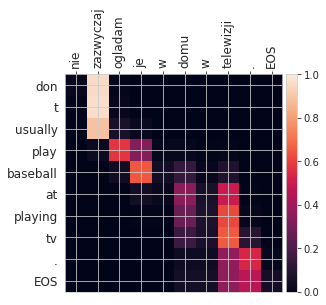

< don t usually play baseball at playing tv . EOS

> tom moglby byc w stanie przekonac mary do tego .
= tom might be able to convince mary to do that .


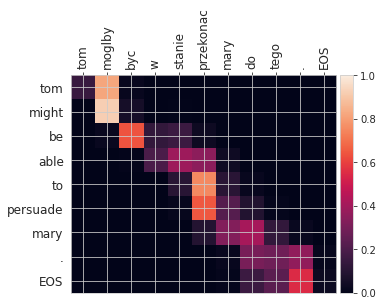

< tom might be able to persuade mary . EOS

> przykro mi ale uwazam ze jestes w bledzie .
= i m sorry but i think you re mistaken .


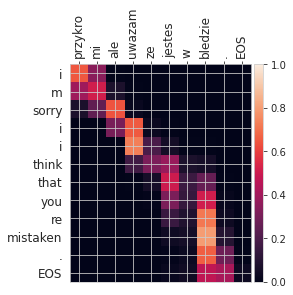

< i m sorry i i think that you re mistaken . EOS

========================= BLEU: 0.25628290091552414 =========================
Epoch: 6. Train loss: 1.632346926196929
========================= Translation test =========================
> nastepnego ranka wyjezdzalem do paryza .
= i was leaving for paris the next morning .


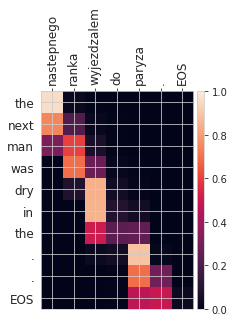

< the next man was dry in the . . EOS

> oni musza byc niespelna rozumu zeby wierzyc w takie bzdury .
= they must be crazy to believe such nonsense .


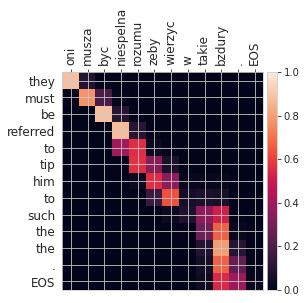

< they must be referred to tip him to such the the . EOS

> nie bawiles sie dobrze ?
= didn t you have fun ?


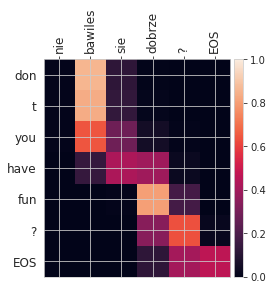

< don t you have fun ? EOS

> jestem ciekawy czy wybuchnie trzecia wojna swiatowa .
= i wonder if a third world war will break out .


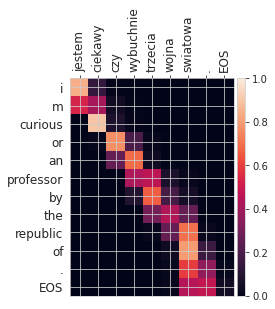

< i m curious or an professor by the republic of . EOS

> nigdy jeszcze nie mialem ucznia ktory by sie zachowywal tak zle jak ty dzisiaj .
= i ve never had a student before that behaved as badly as you did today .


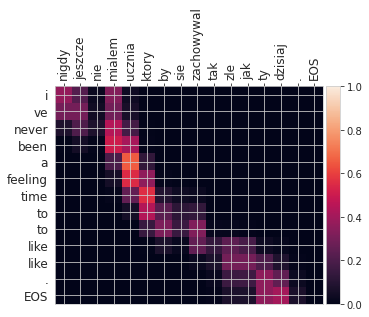

< i ve never been a feeling time to to like like . EOS

========================= BLEU: 0.2585585381081231 =========================
Epoch: 7. Train loss: 1.2677881711272783
========================= Translation test =========================
> sadzilem ze to bedzie prosta robota .
= i thought doing this would be easy .


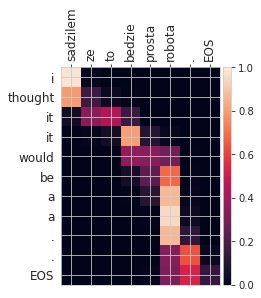

< i thought it it would be a a . . EOS

> przez caly tydzien mielismy piekna pogode .
= we ve had beautiful weather all week .


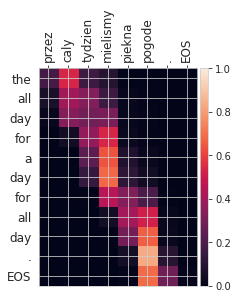

< the all day for a day for all day . EOS

> chce sie upewnic ze moge sobie pozwolic na ten zakup zanim to zamowie .
= i want to make sure i can afford to buy it before i order it .


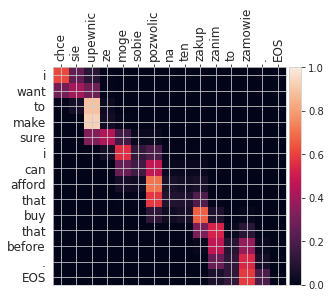

< i want to make sure i can afford that buy that before . EOS

> jaki jest twoj nowy numer telefonu ?
= what s your new telephone number ?


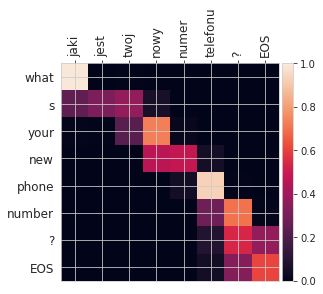

< what s your new phone number ? EOS

> wiedzialem ze klamia !
= i knew they were lying !


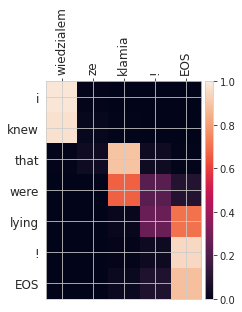

< i knew that were lying ! EOS

========================= BLEU: 0.2741948068141937 =========================
Epoch: 8. Train loss: 0.9665050551455509
========================= Translation test =========================
> to nie jest to czego szukalem .
= this isn t what i was looking for .


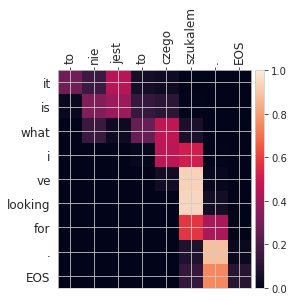

< it is what i ve looking for . EOS

> nie chce cie znow stracic .
= i don t want to lose you again .


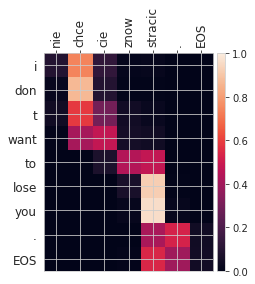

< i don t want to lose you . EOS

> dalej nie mamy wszystkiego czego potrzebujemy .
= we still don t have everything we need .


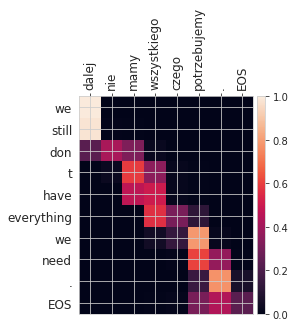

< we still don t have everything we need . EOS

> reagujesz emocjonalnie .
= you re intense .


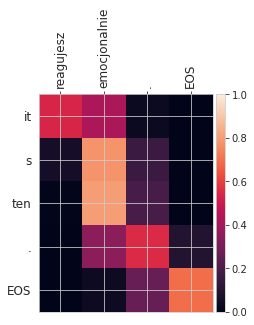

< it s ten . EOS

> alkoholizm jest nieuleczalny .
= alcoholism is incurable .


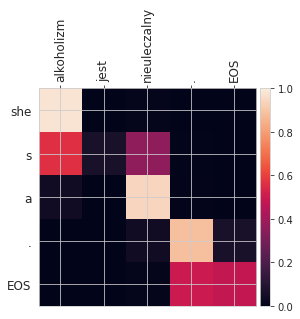

< she s a . EOS

========================= BLEU: 0.2820691462243611 =========================
Epoch: 9. Train loss: 0.7716497061073139
========================= Translation test =========================
> czy wszyscy czekaja ?
= is everyone waiting ?


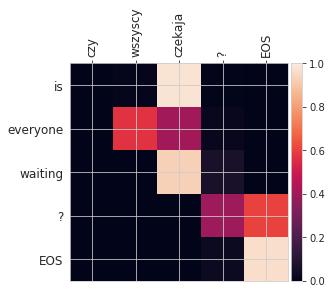

< is everyone waiting ? EOS

> w zimie slonce zachodzi przed czwarta po poludniu .
= the sun sets by p .m . in winter .


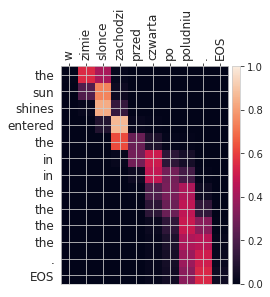

< the sun shines entered the in in the the the the . EOS

> gdzie bylyscie ?
= where were you ?


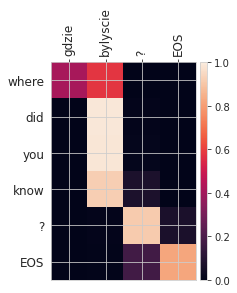

< where did you know ? EOS

> drzwi mojego biura sa zawsze otwarte .
= my office door s always open .


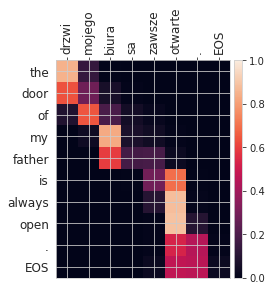

< the door of my father is always open . EOS

> nie chciala mnie zauwazyc .
= she refused to notice me .


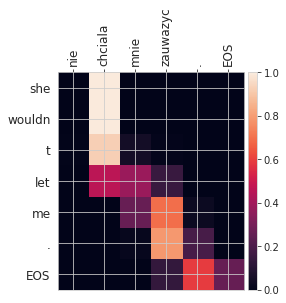

< she wouldn t let me . EOS

========================= BLEU: 0.2816937389336419 =========================
Epoch: 10. Train loss: 0.621832997568192


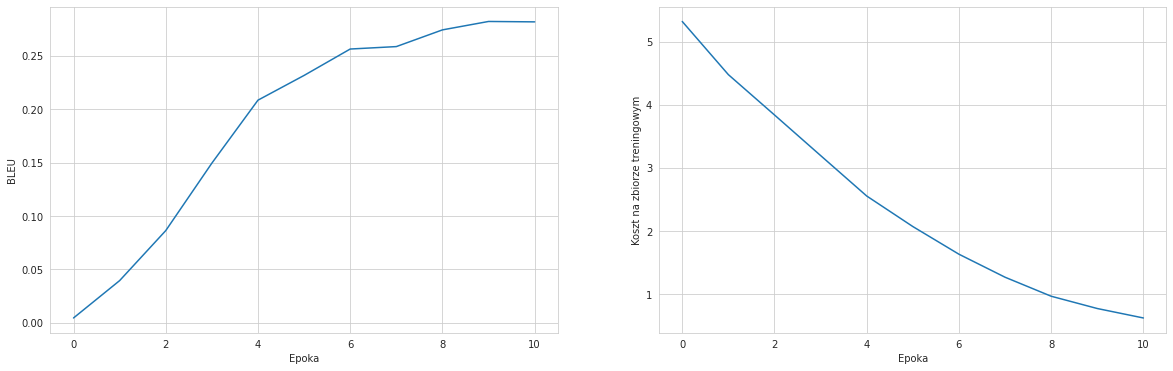

In [15]:
hidden_size = 1024
embedding_size = 512
lr = 1e-3
clip = 0.1
encoder = EncoderRNN(input_lang.n_words, embedding_size, hidden_size).to(device)
decoder = AttnDecoderRNN(output_lang.n_words, embedding_size, hidden_size).to(device)

bleus, losses = train(encoder, decoder, lr=lr, batch_size=512, epochs_num=10, clipping=0.1)
plot_results(bleus, losses)

# Powiązana literatura

* [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)
* [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)

## Przydatne tutoriale

* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
* https://github.com/bentrevett/pytorch-seq2seq
* https://github.com/gmum/AppliedDL2020/tree/master/Week%207 - materiały z kursu Applied Deep Learning prowadzonego w semestrze letnim
